In [4]:
import pandas as pd
import numpy as np
import re
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# 1. Chargement des données
train_data = pd.read_csv('SQLIV3_cleaned2.csv')
test_data = pd.read_csv('sqliv2_utf8.csv')


In [6]:
print(train_data)

                                                Sentence  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2       AND 1  =  utl_inaddr.get_host_address   (    ...      1
3       select * from users where id  =  '1' or @ @1 ...      1
4       select * from users where id  =  1 or 1#"  ( ...      1
...                                                  ...    ...
30609              DELETE FROM door WHERE grow = 'small'      0
30610                               DELETE FROM tomorrow      0
30611                       SELECT wide ( s )  FROM west      0
30612       SELECT * FROM  ( SELECT slide FROM breath )       0
30613                           SELECT TOP 3 * FROM race      0

[30614 rows x 2 columns]


In [7]:
train_data.duplicated().sum()

12

In [8]:
# 2. Suppression des doublons (en gardant la première occurrence)
train_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)
test_data.drop_duplicates(subset='Sentence', keep='first', inplace=True)



In [9]:
train_data.duplicated().sum()

0

In [10]:
# 3. Affichage de la structure des datasets
print("Structure du train_data :")
print(train_data.info())
print("\nStatistiques :")
print(train_data.describe(include='all'))

print("\nStructure du test_data :")
print(test_data.info())

Structure du train_data :
<class 'pandas.core.frame.DataFrame'>
Index: 30600 entries, 0 to 30613
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30600 non-null  object
 1   Label     30600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 717.2+ KB
None

Statistiques :
                                 Sentence         Label
count                               30600  30600.000000
unique                              30600           NaN
top     " or pg_sleep  (  __TIME__  )  --           NaN
freq                                    1           NaN
mean                                  NaN      0.370654
std                                   NaN      0.482988
min                                   NaN      0.000000
25%                                   NaN      0.000000
50%                                   NaN      0.000000
75%                                   NaN      1.000000
max                           

In [11]:
# 4. Nettoyage minimal (on garde les caractères spéciaux)
def clean_text(text):
    return str(text).strip()

train_data['Sentence'] = train_data['Sentence'].apply(clean_text)
test_data['Sentence'] = test_data['Sentence'].apply(clean_text)

In [12]:
train_data

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( (...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30609,DELETE FROM door WHERE grow = 'small',0
30610,DELETE FROM tomorrow,0
30611,SELECT wide ( s ) FROM west,0
30612,SELECT * FROM ( SELECT slide FROM breath ),0


In [13]:
# 5. Tokenisation
vocab_size = 15000
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token="<OOV>",
    filters='',        # Garde les caractères spéciaux
    lower=False
)
tokenizer.fit_on_texts(train_data['Sentence'])


In [14]:
print(train_data)

                                                Sentence  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2      AND 1  =  utl_inaddr.get_host_address   (    (...      1
3      select * from users where id  =  '1' or @ @1  ...      1
4      select * from users where id  =  1 or 1#"  (  ...      1
...                                                  ...    ...
30609              DELETE FROM door WHERE grow = 'small'      0
30610                               DELETE FROM tomorrow      0
30611                       SELECT wide ( s )  FROM west      0
30612        SELECT * FROM  ( SELECT slide FROM breath )      0
30613                           SELECT TOP 3 * FROM race      0

[30600 rows x 2 columns]


In [15]:
# 6. Séquences et padding
max_len = int(np.percentile([len(x.split()) for x in train_data['Sentence']], 95))
X = tokenizer.texts_to_sequences(train_data['Sentence'])
X = pad_sequences(X, padding='post', maxlen=max_len)
y = train_data['Label'].astype('int')


In [16]:
# 7. Split train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# 8. Architecture du modèle LSTM
embedding_dim = 256
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [18]:
# 9. Compilation du modèle
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [19]:
# 11. Entraînement
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
)

Epoch 1/30
383/383 [==============================] - 98s 240ms/step - loss: 0.1821 - accuracy: 0.9339 - val_loss: 0.0300 - val_accuracy: 0.9954
Epoch 2/30
383/383 [==============================] - 91s 239ms/step - loss: 0.0278 - accuracy: 0.9955 - val_loss: 0.0247 - val_accuracy: 0.9961
Epoch 3/30
383/383 [==============================] - 93s 242ms/step - loss: 0.0310 - accuracy: 0.9944 - val_loss: 0.1308 - val_accuracy: 0.9690
Epoch 4/30
383/383 [==============================] - 93s 243ms/step - loss: 0.0588 - accuracy: 0.9878 - val_loss: 0.0356 - val_accuracy: 0.9936
Epoch 5/30
383/383 [==============================] - 93s 244ms/step - loss: 0.0358 - accuracy: 0.9937 - val_loss: 0.0340 - val_accuracy: 0.9940
Epoch 6/30
383/383 [==============================] - 93s 243ms/step - loss: 0.0325 - accuracy: 0.9943 - val_loss: 0.0315 - val_accuracy: 0.9944
Epoch 7/30
383/383 [==============================] - 94s 245ms/step - loss: 0.0306 - accuracy: 0.9947 - val_loss: 0.0268 - val_ac

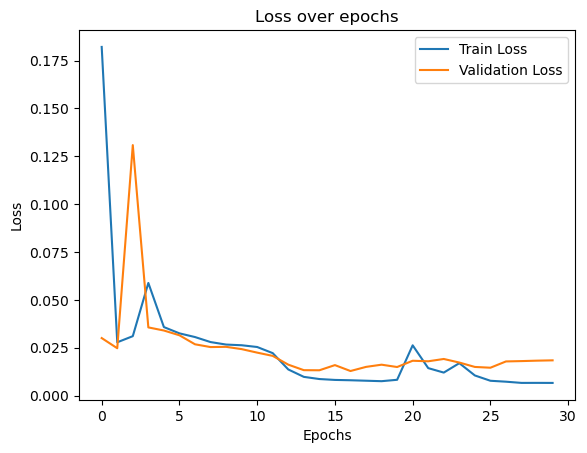

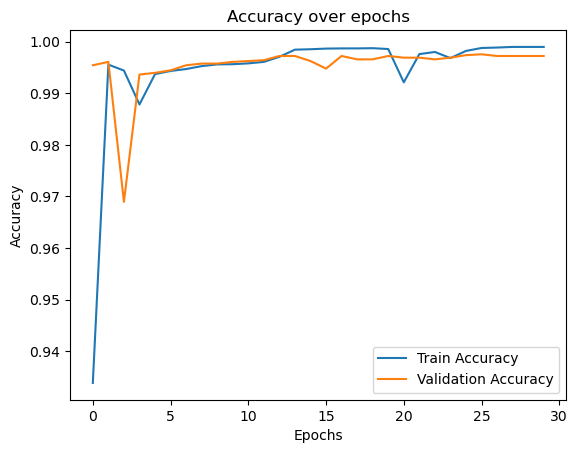

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
X_test = tokenizer.texts_to_sequences(test_data['Sentence'])
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
y_test = test_data['Label'].astype('int')
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'\n✅ Test Accuracy: {test_accuracy:.4f}')
print(f'❌ Test Loss: {test_loss:.4f}')

1054/1054 [==============================] - 52s 49ms/step - loss: 0.0481 - accuracy: 0.9945

✅ Test Accuracy: 0.9945
❌ Test Loss: 0.0481


In [22]:
# 8. Évaluation sur les SQLi (label = 1 uniquement)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

sqli_only = test_data[test_data['Label'] == 1].copy()
print(f"\n📌 Nombre total des injections SQL dans test_data : {len(sqli_only)}")

# Nettoyage éventuel
sqli_only['Sentence'] = sqli_only['Sentence'].apply(clean_text)

# Tokenisation + Padding
X_sqli = tokenizer.texts_to_sequences(sqli_only['Sentence'])
X_sqli = pad_sequences(X_sqli, padding='post', maxlen=max_len)
y_sqli_true = np.ones(len(sqli_only))  # Tous sont censés être des injections

# Prédiction
sqli_preds = model.predict(X_sqli)
sqli_preds_labels = (sqli_preds > 0.5).astype(int)

# Métriques
true_positives = np.sum(sqli_preds_labels == 1)
detection_rate = (true_positives / len(sqli_only)) * 100
accuracy = accuracy_score(y_sqli_true, sqli_preds_labels)
precision = precision_score(y_sqli_true, sqli_preds_labels)
recall = recall_score(y_sqli_true, sqli_preds_labels)
f1 = f1_score(y_sqli_true, sqli_preds_labels)

# Affichage
print(f"\n✅ Injections correctement détectées : {true_positives}")
print(f"📊 Taux de détection : {detection_rate:.2f}%")
print(f"\n🔍 Évaluation sur les requêtes SQL (Label = 1) :")
print(f"✅ Accuracy  : {accuracy * 100:.2f}%")
print(f"✅ Precision : {precision * 100:.2f}%")
print(f"✅ Recall    : {recall * 100:.2f}%")
print(f"✅ F1 Score  : {f1 * 100:.2f}%")


📌 Nombre total des injections SQL dans test_data : 11424
357/357 [==============================] - 22s 58ms/step

✅ Injections correctement détectées : 11360
📊 Taux de détection : 99.44%

🔍 Évaluation sur les requêtes SQL (Label = 1) :
✅ Accuracy  : 99.44%
✅ Precision : 100.00%
✅ Recall    : 99.44%
✅ F1 Score  : 99.72%


In [24]:
# 8. Évaluation sur les requêtes normales (label = 0 uniquement)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

normal_only = test_data[test_data['Label'] == 0].copy()
print(f"\n📌 Nombre total des requêtes normales dans test_data : {len(normal_only)}")

# Nettoyage éventuel
normal_only['Sentence'] = normal_only['Sentence'].apply(clean_text)

# Tokenisation + Padding
X_normal = tokenizer.texts_to_sequences(normal_only['Sentence'])
X_normal = pad_sequences(X_normal, padding='post', maxlen=max_len)
y_normal_true = np.zeros(len(normal_only))  # Tous sont censés être des requêtes normales

# Prédiction
normal_preds = model.predict(X_normal)
normal_preds_labels = (normal_preds > 0.5).astype(int)

# Affichage des métriques
print("\n📊 Évaluation sur les requêtes normales (Label = 0):")
print(f"✅ Accuracy : {accuracy_score(y_normal_true, normal_preds_labels) * 100:.2f}%")
print(f"✅ Precision : {precision_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")
print(f"✅ Recall : {recall_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")
print(f"✅ F1 Score : {f1_score(y_normal_true, normal_preds_labels, pos_label=0, zero_division=0) * 100:.2f}%")



📌 Nombre total des requêtes normales dans test_data : 22302
697/697 [==============================] - 29s 42ms/step

📊 Évaluation sur les requêtes normales (Label = 0):
✅ Accuracy : 99.46%
✅ Precision : 100.00%
✅ Recall : 99.46%
✅ F1 Score : 99.73%
